# Install and Import Necessary Dependencies

In [19]:
!pip install torch
!pip install transformers pandas numpy
!pip install unidecode contractions pyspellchecker wordninja symspellpy

import os
import pandas as pd
import numpy as np
import nltk
import unidecode
import contractions
import wordninja
import re
import pkg_resources
from spellchecker import SpellChecker
from symspellpy import SymSpell, Verbosity
from nltk.corpus import stopwords
from transformers.pipelines import text_generation
from textblob import TextBlob
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
from keras.preprocessing.text import Tokenizer
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

# nltk.download('stopwords')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Data

Data obtained from https://www.kaggle.com/datasets/nikhileswarkomati/suicide-watch?resource=download





In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
try:
  os.chdir('/content/drive/MyDrive/Personal Projects/Suicidal-BERT Project')
  print('Directory change successful')
except OSError:
  print('Directory change failed')

Directory change successful


In [5]:
# Load data set

df = pd.read_csv('Data/Suicide_Detection.csv')
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [6]:
df.shape

(232074, 3)

# Preprocess Data

Why?

Preprocessing standardizes the text so that computer models can better understand and work with human input. It also reduces computational complexity when model training. We want to avoid scenerios where words such as "Game" and "game" are counted as 2 different words.

Tasks:
- Fix spelling errors
- Change all letters to lowercase
- Remove stop words (words that do not contribute to the overall meaning of the text)
- Expand contractions (I've ➡ I have)
- Remove extra whitespaces
- Remove accents, URLs, symbols and digits




In [ ]:
sym_spell = SymSpell(max_dictionary_edit_distance=3)
dictionary_path = pkg_resources.resource_filename("symspellpy", "frequency_dictionary_en_82_765.txt")
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

In [11]:
stop_words = stopwords.words('english')
selected_stop_words = [word for word in stop_words if word not in ['no', 'not']]

# Defining preprocessing methods

# Spell check and change to lowercase with Symspell
def fix_spelling(text):
  suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
  return suggestions[0].term

def remove_stop_words(text):
  return ' '.join([word for word in text.split(' ') if word not in stop_words])

def remove_whitespace(text):
  text = text.strip()
  return ' '.join(text.split())

def expand_contractions(text):
  return contractions.fix(text)

def remove_accents(text):
  return unidecode.unidecode(text)

def remove_urls(text):
  return re.sub(r'http\S+', '', text)

def remove_symbols_digits(text):
  return re.sub('[^a-zA-Z\s]', ' ', text)

def remove_special(text):
  return text.replace("\r", " ").replace("\n", " ").replace("    ", " ").replace('"', '')

def fix_lengthening(text):
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

def text_preprocessing(text):
  text = fix_spelling(text)
  text = remove_stop_words(text)
  text = remove_whitespace(text)
  text = expand_contractions(text)
  text = remove_accents(text)
  text = remove_urls(text)
  text = remove_symbols_digits(text)
  text = remove_special(text)
  return text

# Preprocess all the data
df['cleaned_text'] = df['text'].apply(lambda row: text_preprocessing(row))
df[:10]

,Unnamed: 0,text,class,cleaned_text
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threatening suicide recently left wif...
1,3,Am I weird I don't get affected by compliments...,non-suicide,weird get affected compliments coming someone ...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally almost never hear bad year ever swear ...
3,8,i need helpjust help me im crying so hard,suicide,need help help crying hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,ism lost hello name adam i have struggling yea...
5,11,Honetly idkI dont know what im even doing here...,suicide,honestly id done know even feel like nothing n...
6,12,[Trigger warning] Excuse for self inflicted bu...,suicide,trigger warning excuse self inflicted burns kn...
7,13,It ends tonight.I can’t do it anymore. \nI quit.,suicide,ends tonight cannot anymore quit
8,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,everyone wants edgy making self conscious feel...
9,18,My life is over at 20 years oldHello all. I am...,suicide,life years old hello year old balding male hai...


In [12]:
# Save cleaned data to Google Drive

df.to_csv('Suicide_Detection_Cleaned.csv', index=False)

# Data Cleaning

In [17]:
# Examine frequency of words

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])
word_freq = pd.DataFrame(tokenizer.word_counts.items(), columns=['word','count']).sort_values(by='count', ascending=False)
word_freq.head()

,word,count
26,i,365769
50,am,221219
111,like,182587
350,want,166003
29,know,133111


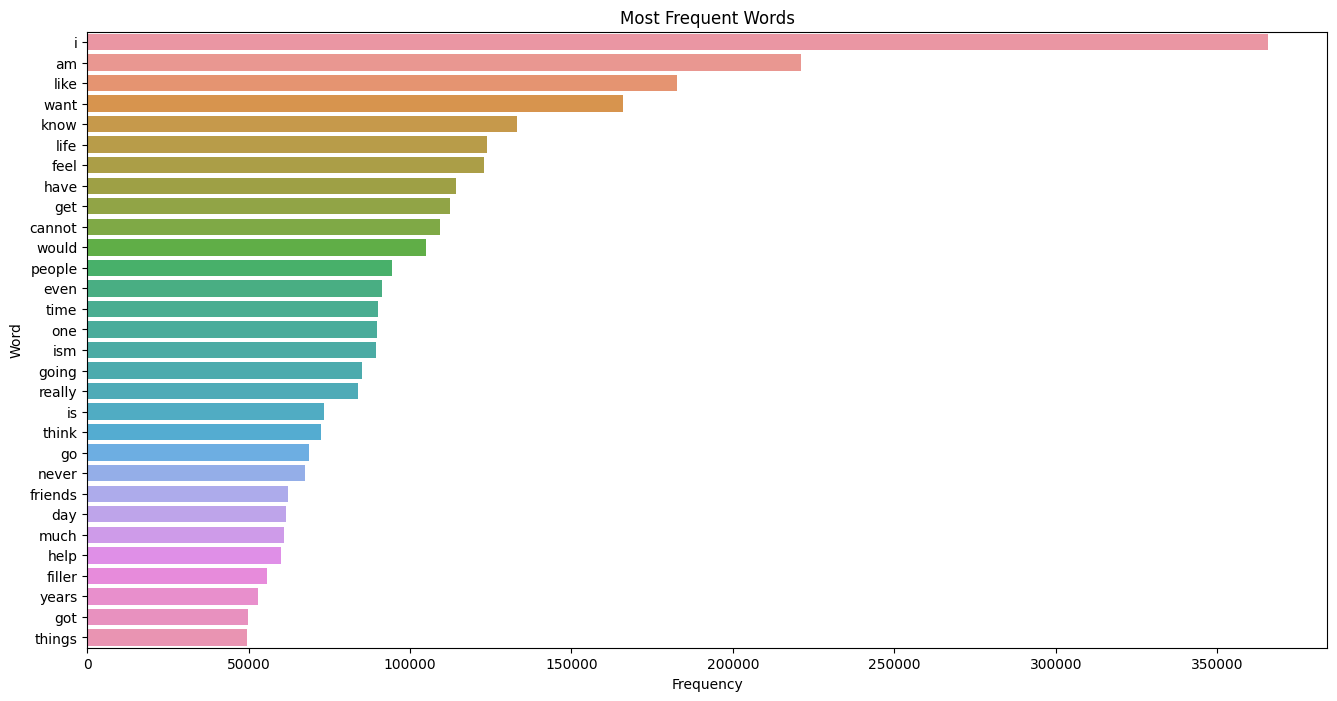

In [20]:
# Plot word frequency

plt.figure(figsize=(16, 8))
sns.barplot(x='count',y='word',data=word_freq.iloc[:30])
plt.title('Most Frequent Words')
plt.xlabel("Frequency")
plt.ylabel("Word")
plt.show()

In [27]:
# Remove "filler"

df['cleaned_text'] = df['cleaned_text'].str.replace('filler', '')

In [ ]:
# Save final cleaned data set

df.to_csv('Suicide_Detection_Cleaned_Final.csv', index=False)

# Exploratory Data Analysis (EDA)



Tasks:
- Sentinment analysis using TextBlob's Sentinment() function (-1 represents a negative attitude and +1 represents a positive attitude)
- Term frequency analysis


In [68]:
# Load cleaned data set

df = pd.read_csv('Data/Suicide_Detection_Cleaned.csv')
df.head()

,Unnamed: 0,text,class,cleaned_text
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threatening suicide recently left wif...
1,3,Am I weird I don't get affected by compliments...,non-suicide,weird get affected compliments coming someone ...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally almost never hear bad year ever swear ...
3,8,i need helpjust help me im crying so hard,suicide,need help help crying hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,ism lost hello name adam i have struggling yea...


In [69]:
df.shape

(232005, 4)

# Sentiment Analysis

In [41]:
df['sentiment'] = df['cleaned_text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df.head()

,Unnamed: 0,text,class,cleaned_text,sentiment
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,sex wife threatening suicide recently left wif...,0.116667
1,3,Am I weird I don't get affected by compliments...,non-suicide,weird get affected compliments coming someone ...,0.100000
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally almost never hear bad year ever swear ...,-0.525000
3,8,i need helpjust help me im crying so hard,suicide,need help help crying hard,-0.245833
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,ism lost hello name adam i have struggling yea...,-0.221131


# Term Frequency and Word Cloud

In [59]:
df = df.rename(columns={'class': 'classification'}) # class is a reserved keyword
df['split_text'] = df['cleaned_text'].apply(lambda row: str(row).split(' '))

In [65]:
# Most frequent words in suicidal texts

suicidal_words = df[df.classification == 'suicide'].cleaned_text.tolist()

['done know feel way think killing every single day fact multiple times day done know live got good friends great grades live got loving family anything might want still feel like shit done know gotten feeling life pointless study another years get job work die thing day day rest life things come worst kill consequences sure family grieve main reason done friends fine year less legacy even kill legacy die none never special maybe need vent done know want seek help scared family would react they have already got enough going lives', nan]


In [56]:
# Most frequent words in non-suicidal texts

non_suicidal_words = df[df.classification == 'non-suicide']

# Fine-tuning BERT

In [ ]:
device = torch.device("cuda")

In [ ]:
# Constants

SEED = 2023

## Split the Data Set into Training, Validation, and Test Sets

In [ ]:
x_train, x_temp, y_train, y_temp = train_test_split(df['text'], df['class'], random_state=SEED, test_size=0.2, stratify=df['class'])

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, random_state=SEED, test_size=0.5, stratify=y_temp)

## Import BERT Model and Tokenizer 

In [ ]:
model = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
